# Pneunomia detection

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Step: Reading pictures in

In [2]:

# lehetséges modellek amik jók lehetnek: resnet50(ezzel csináltam a betűfelismerést), sequential(ez vol kaggle-on), svm(ez volt amm órán),

ütemterv:
- Rövid helyzetjelentés emailben (sikerült-e a haladni, mi a helyzet), minden héten kedden (akkor is, ha épp nem volt rá idő vagy energia)
- Április 10-ig: kész és dokumentált feltáró adatelemzés (EDA)
- Április 19-ig: teljes, kész irodalomkutatás - adatbányászat + EDA alapok + gépi tanulás és algoritmusok melyeket használni fogsz
- Május 7-ig: elkészült gépi tanulási modellek és az eredmények értékelése
- Május 13-ig: Benyújtásra kész, általad véglegesnek ítélt dokumentáció elküldése nekem (az osztályzatnál figyelembe lesz véve az állapota)
- Május 24-ig: Az egyetemnek benyújtott dokumentáció (végső értékeléshez)
- Teljesen kész prezentáció a prezentáció előtt egy héttel legalább

In [4]:
'''!pip install tensorflow
!pip install keras
!pip install tqdm
!pip install opencv-python'''

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL
import tensorflow as tf
import pandas as pd

'''from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential'''

import cv2
import tqdm
import glob

#resnet importalasa
'''from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions'''

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 103.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 7.9 MB/s eta 0:00:00


'from keras.applications.resnet50 import ResNet50\nfrom keras.applications.resnet50 import preprocess_input, decode_predictions'

In [5]:
# beolvasas
'''train_normal = [cv2.imread(file) for file in tqdm.tqdm(glob.glob("archive/chest_xray/train/NORMAL/*.jpeg"), desc = "Betoltes") ]
train_pneunomia = [cv2.imread(file) for file in tqdm.tqdm(glob.glob("archive/chest_xray/train/PNEUMONIA/*.jpeg"), desc = "Betoltes") ]'''

'train_normal = [cv2.imread(file) for file in tqdm.tqdm(glob.glob("archive/chest_xray/train/NORMAL/*.jpeg"), desc = "Betoltes") ]\ntrain_pneunomia = [cv2.imread(file) for file in tqdm.tqdm(glob.glob("archive/chest_xray/train/PNEUMONIA/*.jpeg"), desc = "Betoltes") ]'

In [6]:
train_normal = [cv2.imread(file) for file in tqdm.tqdm(glob.glob("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/train/NORMAL/*.jpeg"), desc = "Betoltes") ]

train_pneunomia = [cv2.imread(file) for file in tqdm.tqdm(glob.glob("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/train/PNEUMONIA/*.jpeg"), desc = "Betoltes") ]


Betoltes: 100%|██████████| 3895/3895 [01:37<00:00, 39.91it/s]


In [7]:
len(train_normal)
len(train_pneunomia)

3895

# Feltáró adatelemzés (Exploratory Data Analysis)

<Axes: title={'center': 'Number of images by class'}, xlabel='Class name', ylabel='Number of pictures'>

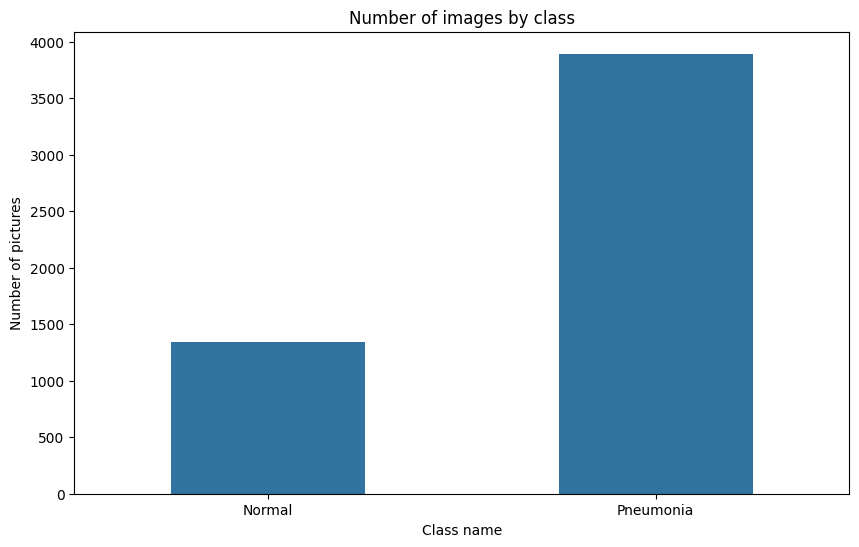

In [8]:
# class imbalance:
#making it a dictionary
classes = {'Normal':len(train_normal), 'Pneumonia':len(train_pneunomia) }
plt.figure(figsize=(10,6))
plt.title('Number of images by class')
plt.xlabel('Class name')
plt.ylabel('Number of pictures')
sns.barplot(classes,width=0.5)



Konklúzió: Látható, hogy fetőzött tüdőről lényegesen több kép van mint normálisról, ezáltal előfordulhat egyenlőtlenség

In [9]:
# checking the image sizes
def get_dimensions(dataset):
    dimensions = pd.DataFrame(columns=['height', 'width'])
    for i in range(0, len(dataset)):
        im = dataset[i]
        array = np.array(im)
        h,w,d = array.shape
        dimensions.loc[len(dimensions)] = [h,w]
    return dimensions

In [10]:
normal_df = get_dimensions(train_normal)

<Axes: title={'center': 'Distribution of image sizes for normal lungs'}, xlabel='height', ylabel='width'>

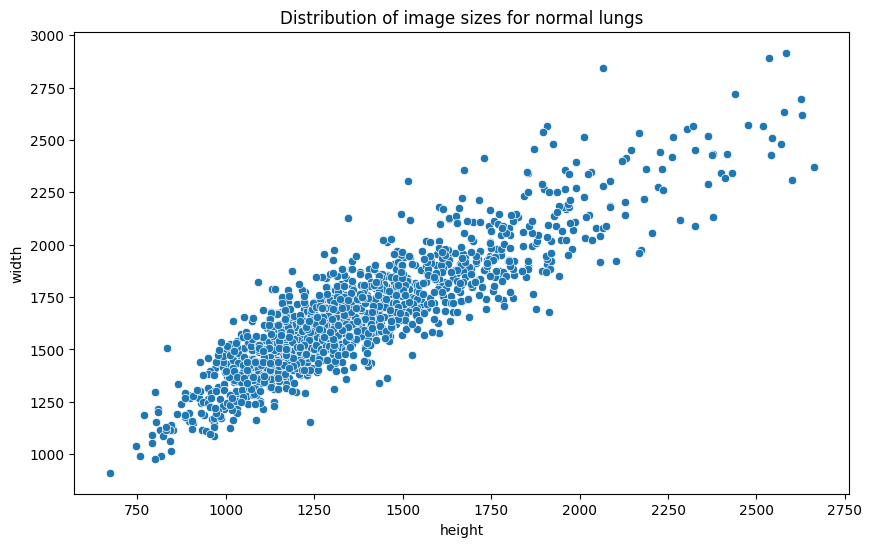

In [11]:
# plotting image sizes
plt.figure(figsize=(10,6))
plt.title('Distribution of image sizes for normal lungs')
sns.scatterplot(data=normal_df, x='height', y='width')

In [12]:
pneumonia_df = get_dimensions(train_pneunomia)

<Axes: title={'center': 'Distribution of image sizes for infected lungs'}, xlabel='height', ylabel='width'>

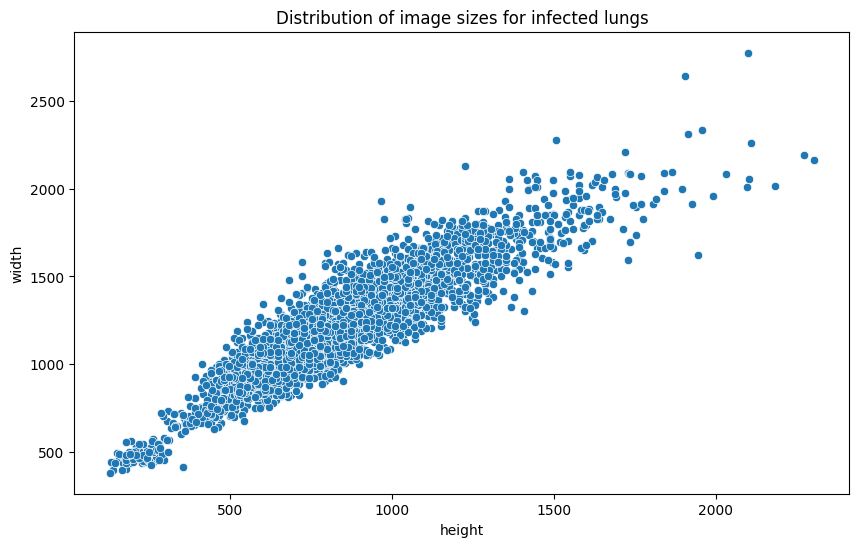

In [13]:
plt.figure(figsize=(10,6))
plt.title('Distribution of image sizes for infected lungs')
sns.scatterplot(data=pneumonia_df, x='height', y='width')

Konklúzió: A képek egyáltalán nem egységesek, nagyon sokféle méretben vannak jelen az adatbázisban

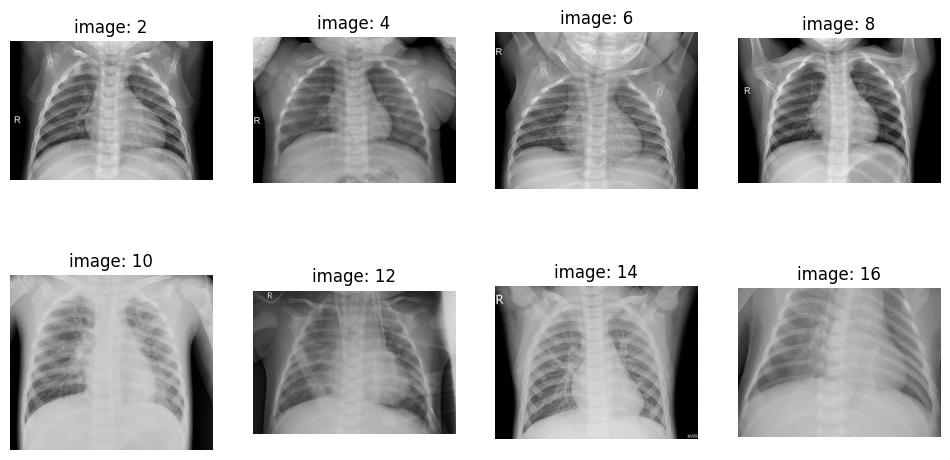

In [14]:
# Showing examples from each class
plt.figure(figsize=(12,6))
for i in range(1, 9):
    plt.subplot(2, 4, i) #sor,oszlop,melyiknel legyen epp
    if i < 5:
        plt.imshow(train_normal[i*2])
        plt.title(f"image: {i*2}")
        plt.axis('off')
    else:
        plt.imshow(train_pneunomia[i*2])
        plt.axis('off')
        plt.title(f"image: {i*2}")


In [15]:
#resizing the images for faster calculations with keeping the aspect ratio
'''def resize_with_keeping_ratio(images):
    resized_images = []
    for image in images:
        # Get the original dimensions
        (h, w) = image.shape[:2]

        # Desired width
        new_width = 256

        # Calculate the aspect ratio
        aspect_ratio = h / w
        new_height = int(new_width * aspect_ratio)

        # Resize the image
        resized_image = cv2.resize(image, (new_width, new_height))
        resized_images.append(resized_image)
    return resized_images'''
#hatekonyabb
def resize_with_keeping_ratio(images, new_width=256):
    return [cv2.resize(img, (new_width, int(new_width * img.shape[0] / img.shape[1]))) for img in images]

In [16]:
resized_normal = resize_with_keeping_ratio(train_normal)
resized_pneumonia = resize_with_keeping_ratio(train_pneunomia)

In [17]:
'''import os
#i would like to save these resized image so that i can read these in for further work and use these for training the model
# currently im not sure if this is necessary so i come back later to that problem
def save_images(images, origin_path, output_folder) :
    #Az eredeti fájlnevek listája
    original_filenames = [os.path.basename(path) for path in origin_path]

    # A célmappa létrehozása, ha nem létezik
    os.makedirs(output_folder, exist_ok=True)

    # Mentés az eredeti fájlnevekkel
    for i in range(len(images)):
        save_path = os.path.join(output_folder, original_filenames[i])
        cv2.imwrite(save_path, images[i])
        print(f"Mentve: {save_path}")


# glob saves the filenames as a list
normal = glob.glob("archive/chest_xray/train/NORMAL/*.jpeg")
pneumonia = glob.glob("archive/chest_xray/train/PNEUMONIA/*.jpeg")'''

'import os\n#i would like to save these resized image so that i can read these in for further work and use these for training the model\n# currently im not sure if this is necessary so i come back later to that problem\ndef save_images(images, origin_path, output_folder) :\n    #Az eredeti fájlnevek listája\n    original_filenames = [os.path.basename(path) for path in origin_path]\n\n    # A célmappa létrehozása, ha nem létezik\n    os.makedirs(output_folder, exist_ok=True)\n\n    # Mentés az eredeti fájlnevekkel\n    for i in range(len(images)):\n        save_path = os.path.join(output_folder, original_filenames[i])\n        cv2.imwrite(save_path, images[i])\n        print(f"Mentve: {save_path}")\n\n\n# glob saves the filenames as a list\nnormal = glob.glob("archive/chest_xray/train/NORMAL/*.jpeg")\npneumonia = glob.glob("archive/chest_xray/train/PNEUMONIA/*.jpeg")'

In [18]:
# Images as matrix
from tensorflow.keras.preprocessing import image
img = image.img_to_array(resized_normal[0])

In [19]:
import os
def img2np(path, list_of_filename, size=(64, 64)):
    full_mat = []  # Üres lista kezdetben

    for fn in list_of_filename:
        fp = os.path.join(path, fn)  # Helyes fájlelőérési útvonal
        current_image = image.load_img(fp, target_size=size, color_mode='grayscale')
        img_ts = image.img_to_array(current_image).ravel()  # 1D tömb

        full_mat.append(img_ts)  # Hozzáadjuk a listához

    return np.array(full_mat, dtype=np.float32)  # NumPy tömbbé alakítás

In [38]:
list_of_files = os.listdir("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/train/NORMAL/")
normal_array = img2np("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/train/NORMAL/",list_of_files)
#Ide azért majd kéne egy kis magyarázat, jelenleg fogalmam sincs mit csinál
#pneumonia_array = img_to_np(resized_pneumonia)

In [39]:
# how does the average image looks like
def mean_img(matrix_array, title, img_size=(64, 64)):
    matrix_array = np.array(matrix_array)  # Biztosítjuk, hogy NumPy tömb
    mean = np.mean(matrix_array, axis=0)  # Átlagolás a képek dimenziója mentén
    mean = mean.reshape(img_size)  # Visszaalakítás 2D formába

    plt.imshow(mean, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()

    return mean

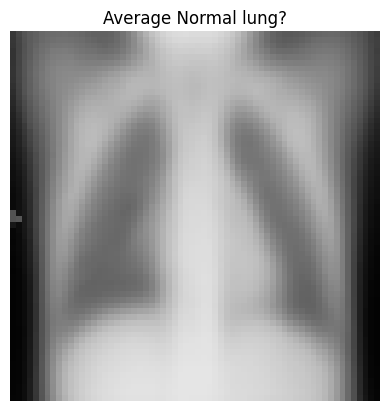

In [40]:
ANL = mean_img(normal_array,"Normal lung?") # ANL = Average Normal Lung

In [41]:
list_of_files = os.listdir("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/train/PNEUMONIA/")
normal_array = img2np("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/train/PNEUMONIA/",list_of_files)

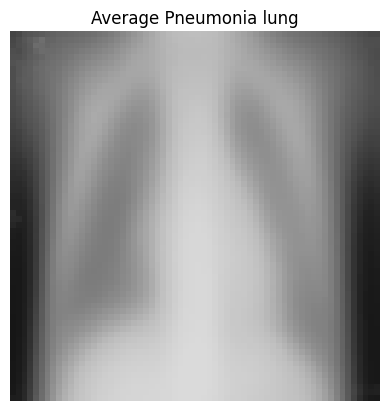

In [42]:
APL = mean_img(normal_array,"Pneumonia lung") # APL = Average Pneumonia Lung

Konklúzió: Látható hogy a fertőzött tüdőknél jobban elhomályosodik a mellkasi rész

Megnézzük a különbséget is a normál és a fertőzött tüdő között

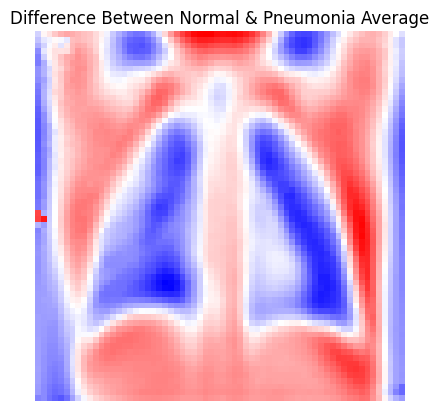

In [45]:
contrast_mean = ANL - APL
plt.imshow(contrast_mean, cmap='bwr')
plt.title(f'Difference Between Normal & Pneumonia Average')
plt.axis('off')
plt.show()
#ez most mit jelent?

Feltáró adatelemzés lezárása, konklúziók összesítése, dokumentálás stb stb.